In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from tqdm.notebook import tqdm

from tools import Sim_Parameters, Train_Parameters, create_dataset, RMSELoss, train_val_test, test_epoch


In [2]:
sim_params = Sim_Parameters(air_trans_file='./data/Test 2 - 21 Substances/Air transmittance.xlsx',
                            air_RI=1,
                            atm_dist_ratio=0.11,
                            basis_func_file='./data/Test 2 - 21 Substances/Basis functions.xlsx',
                            num_substances=6,
                            spectra_file='./data/Test 2 - 21 Substances/spectra.xlsx',
                            substances_emit_file='./data/Test 2 - 21 Substances/substances.xlsx',
                            temp_K=293.15)

In [3]:
dataset = create_dataset(sim_params)
len(dataset)

3003

In [4]:
train_params = Train_Parameters(train_percentage=0.8,
                                batch_size=len(dataset) // 10,
                                criterions=[nn.L1Loss(), RMSELoss, nn.MSELoss()],
                                learning_rate=1e-3,
                                num_epochs=1000,
                                device=torch.device("cpu"),
                                k_fold_flag=True,
                                k=5,
                                random_flag=True,
                                random_seed=28)


FOLD 1


  0%|          | 0/1000 [00:00<?, ?it/s]


FOLD 2


  0%|          | 0/1000 [00:00<?, ?it/s]


FOLD 3


  0%|          | 0/1000 [00:00<?, ?it/s]


FOLD 4


  0%|          | 0/1000 [00:00<?, ?it/s]


FOLD 5


  0%|          | 0/1000 [00:00<?, ?it/s]

avg loss = 0.012749875170128369
best loss = 0.011031623643178206
best model index = 0


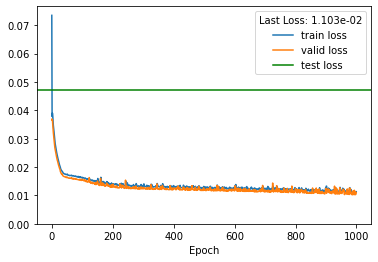

[0.3022881  0.43345226 0.04706044]


In [5]:
history, models, test_loss, pred_list, targ_list = train_val_test(dataset, train_params, sim_params)

print(test_loss)

In [2]:
# Base line

epoch = 1000

MSE = []
avg_MSE = []
RMSE = []
avg_RMSE = []
L1Loss = []
avg_L1Loss = []


mseloss = nn.MSELoss()
l1loss = nn.L1Loss()

for i in tqdm(range(epoch)):
    
    target_loader = DataLoader(dataset, batch_size=1, shuffle=True)
    pred_loader = DataLoader(dataset, batch_size=1, shuffle=True)
    pred_loader_iter = iter(pred_loader)

    for x, target in target_loader:

        xx, pred = next(pred_loader_iter)

        MSE.append(mseloss(pred, target).item())
        RMSE.append(RMSELoss(pred, target).item())
        L1Loss.append(l1loss(pred, target).item())
        
    avg_MSE.append(np.mean(MSE))
    avg_RMSE.append(np.mean(RMSE))
    avg_L1Loss.append(np.mean(L1Loss))

print(avg_MSE[-1])
print(avg_RMSE[-1])
print(avg_L1Loss[-1])

plt.plot(avg_MSE)
plt.plot(avg_RMSE)
plt.plot(avg_L1Loss)

plt.legend(['avg_MSE', 'avg_RMSE', 'avg_L1Loss'])


  0%|          | 0/1000 [00:00<?, ?it/s]

NameError: name 'dataset' is not defined

avg loss = 0.027561439329927617
best loss = 0.019624309614300728
best model index = 4


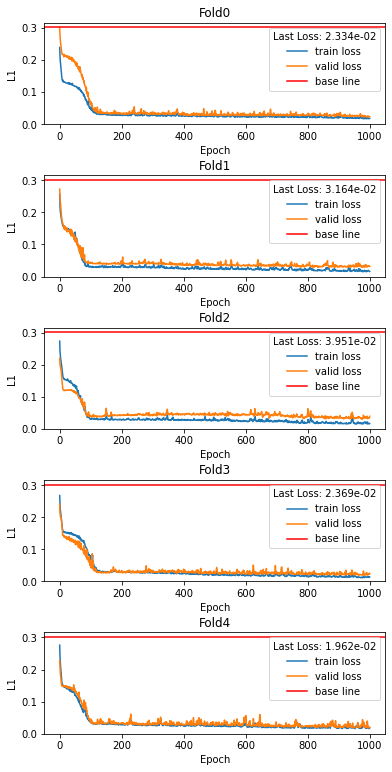

In [ ]:
# Plot k fold
fig, axs = plt.subplots(train_params.k, figsize=(6, 11))
fig.tight_layout(pad=3)
# np.set_printoptions(formatter={'float': '{: 0.2f}'.format})
loss = []
loss_func_index = 0
base_line_loss = [avg_L1Loss[-1], avg_RMSE[-1], avg_MSE[-1]]
base_line_names = ['L1', 'RMSE', 'MSE']
# avg_loss = 0
for i in range (5):
    axs[i].plot(history[i]['train_loss'][:, loss_func_index])
    axs[i].plot(history[i]['valid_loss'][:, loss_func_index])
    axs[i].axhline(base_line_loss[loss_func_index], color='r')
    
    axs[i].set_ylim(bottom=0)
    axs[i].set_xlabel('Epoch')
    axs[i].set_ylabel(base_line_names[loss_func_index])
    
    axs[i].legend(['train loss', 'valid loss', 'base line'], 
                  title=f'Last Loss: {"{:0.3e}".format(history[i]["valid_loss"][:, loss_func_index][-1])}')
    
    axs[i].set_title('Fold' + str(i))
    
    loss.append(history[i]["valid_loss"][:, loss_func_index][-1])
    
    
#     avg_loss += history[i]["valid_loss"][-1]
    
avg_loss = np.mean(loss)
best_loss = np.min(loss)
best_model_index = np.argmin(loss)

print("avg loss =", avg_loss)
print("best loss =", best_loss)
print("best model index =", best_model_index)

In [15]:
# Plot k fold test result

criterions = [nn.L1Loss(reduction='mean'), RMSELoss, nn.MSELoss()]

model = models[best_model_index]
test_loader = DataLoader
test_loss, pred_list, targ_list = test_epoch(model, train_params.device, test_loader, criterions)

print(test_loss)

loss_func_index = 0
base_line_loss = [avg_L1Loss[-1], avg_RMSE[-1], avg_MSE[-1]]

test_loss = test_loss / len(test_dataset)

fig, ax = plt.subplots(figsize=(6, 4))
ax.plot(history[best_model_index]['train_loss'][:, loss_func_index])
ax.plot(history[best_model_index]['valid_loss'][:, loss_func_index])

ax.axhline(base_line_loss[loss_func_index], color='r')
ax.axhline(y=test_loss[loss_func_index], color='g')
    
# ax.plot(avg_RMSE)
# ax.plot(avg_L1Loss)

ax.set_ylim(bottom=0)
ax.set_xlabel('Epoch')
ax.set_ylabel(base_line_names[loss_func_index])
ax.legend(['train loss', 'valid loss', 'base line', 'test loss'], 
          title=f'Last Loss: {"{:0.3e}".format(history[best_model_index]["valid_loss"][:, loss_func_index][-1])}')

np.set_printoptions(formatter={'float': '{: 0.2f}'.format})
for i in range(10):
    print('Target: ', targ_list[i])
    print('Predict:', pred_list[i], '\n')
print(loss[loss_func_index])

NameError: name 'device' is not defined